In [24]:
#pip install xlsxwriter openpyxl

In [2]:
import pandas as pd

import json
import numpy as np
from itertools import permutations
import random
import time
import pprint
import openpyxl

import matplotlib.pyplot as plt

In [3]:
# 배달원 class
class Rider:
    def __init__(self, rider_info):
        # [type, speed, capa, var_cost, fixed_cost, service_time, available number]
        self.type = rider_info[0]
        self.speed = rider_info[1]
        self.capa = rider_info[2]
        self.var_cost = rider_info[3]
        self.fixed_cost = rider_info[4]
        self.service_time = rider_info[5]
        self.available_number = rider_info[6]
    
    def __repr__(self) -> str:
        return f'Rider([{self.type}, {self.speed}, {self.capa}, {self.var_cost}, {self.fixed_cost}, {self.service_time}, {self.available_number}])'
    
    # 주어진 거리에 대한 배달원 비용 계산
    # = 배달원별 고정비 + 이동거리로 계산된 변동비
    def calculate_cost(self, dist):
        return self.fixed_cost + dist / 100.0 * self.var_cost
    
class Order:
    def __init__(self, order_info):
        # [ORD_ID, ORD_TIME, SHOP_LAT, SHOP_LON, DLV_LAT, DLV_LON, COOK_TIME, VOL, DLV_DEADLINE]
        self.id = order_info[0]
        self.order_time = order_info[1]
        self.shop_lat = order_info[2]
        self.shop_lon = order_info[3]
        self.dlv_lat = order_info[4]
        self.dlv_lon = order_info[5]
        self.cook_time = order_info[6]
        self.volume = order_info[7]
        self.deadline = order_info[8]

        self.ready_time = self.order_time + self.cook_time

    def __repr__(self) -> str:
        return f'Order([{self.id}, {self.order_time}, {self.shop_lat}, {self.shop_lon}, {self.dlv_lat}, {self.dlv_lon}, {self.volume}, {self.cook_time}, {self.deadline}])'

In [27]:
col = []
for category in ['Walk','Bike','Car'] :
    col.append(category+'_speed')
    col.append(category+'_capacity')
    col.append(category+'_F_cost')
    col.append(category+'_V_cost')

col = col + ['avg_DIST', 'avg_order_capa']

result = pd.DataFrame(columns=col)
result.head()

Empty DataFrame
Columns: [Walk_speed, Walk_capacity, Walk_F_cost, Walk_V_cost, Bike_speed, Bike_capacity, Bike_F_cost, Bike_V_cost, Car_speed, Car_capacity, Car_F_cost, Car_V_cost, avg_DIST, avg_order_capa]
Index: []

In [28]:
data_frames = {}

for i in range(1,19) :
    problem_name = f'STAGE1_{i}'
    problem_file = rf'C:\Users\user\Desktop\github\OGC2024\stage1_problems\{problem_name}.json'
    with open(problem_file, 'r') as f:
        prob = json.load(f)

    K = prob['K']
    DIST = np.array(prob['DIST'])
    ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]
    ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
    row = dict()
    for rider in ALL_RIDERS :
        if rider.type == 'BIKE' :
            row['Bike_speed'] = rider.speed
            row['Bike_capacity'] = rider.capa
            row['Bike_F_cost'] = rider.fixed_cost
            row['Bike_V_cost'] = rider.var_cost
        if rider.type == 'WALK' :
            row['Walk_speed'] = rider.speed
            row['Walk_capacity'] = rider.capa
            row['Walk_F_cost'] = rider.fixed_cost
            row['Walk_V_cost'] = rider.var_cost
        if rider.type == 'CAR' :
            row['Car_speed'] = rider.speed
            row['Car_capacity'] = rider.capa
            row['Car_F_cost'] = rider.fixed_cost
            row['Car_V_cost'] = rider.var_cost

    # 대각 요소를 제외한 나머지 요소들 선택
    mask = ~np.eye(DIST.shape[0], dtype=bool)
    non_diagonal_elements = DIST[mask]

    # 나머지 요소들의 평균값 계산
    average_value = non_diagonal_elements.mean()
    row['avg_DIST'] = average_value
    row_df = pd.DataFrame([row], index=[problem_name])
    result = pd.concat([result, row_df])

    #order
    data = []

    for order in ALL_ORDERS:
        data.append([
            order.id,
            order.order_time,
            order.shop_lat,
            order.shop_lon,
            order.dlv_lat,
            order.dlv_lon,
            order.cook_time,
            order.volume,
            order.deadline,
            order.ready_time
        ])

    # 데이터프레임 생성
    globals()[f'Order_{problem_name}'] = pd.DataFrame(data, columns=[
        'ID', 'Order Time', 'Shop Latitude', 'Shop Longitude',
        'Delivery Latitude', 'Delivery Longitude', 'Cook Time',
        'Volume', 'Deadline', 'Ready Time'
    ])

    mean_row = globals()[f'Order_{problem_name}'].mean().to_dict()
    median_row = globals()[f'Order_{problem_name}'].median().to_dict()

    mean_row_df = pd.DataFrame([mean_row], index=['mean'])
    median_row_df = pd.DataFrame([median_row], index=['median'])

    globals()[f'Order_{problem_name}'] = pd.concat([globals()[f'Order_{problem_name}'], mean_row_df])
    globals()[f'Order_{problem_name}'] = pd.concat([globals()[f'Order_{problem_name}'], median_row_df])

    data_frames[f'Order_{problem_name}'] = globals()[f'Order_{problem_name}']

# 각 column 별 평균과 미디언을 계산하여 새로운 행으로 추가
mean_row = result.mean().to_dict()
median_row = result.median().to_dict()

mean_row_df = pd.DataFrame([mean_row], index=['mean'])
median_row_df = pd.DataFrame([median_row], index=['median'])

result = pd.concat([result, mean_row_df])
result = pd.concat([result, median_row_df])

data_frames['problem_description'] = result

# 결과를 엑셀 파일로 저장
with pd.ExcelWriter('OGC2024_problem_description.xlsx', engine='xlsxwriter') as writer:
    for sheet_name, df in data_frames.items():
        df.to_excel(writer, sheet_name=sheet_name)

## Visualization of Orders from each prolblems 

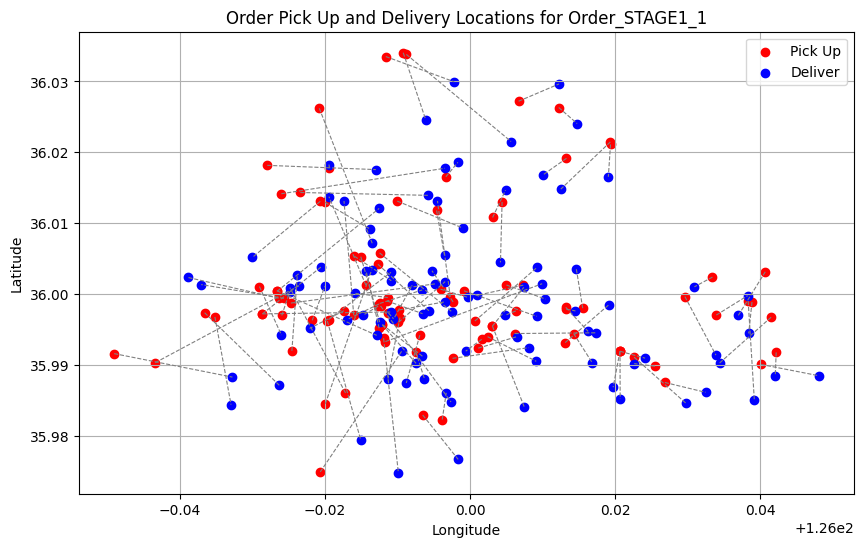

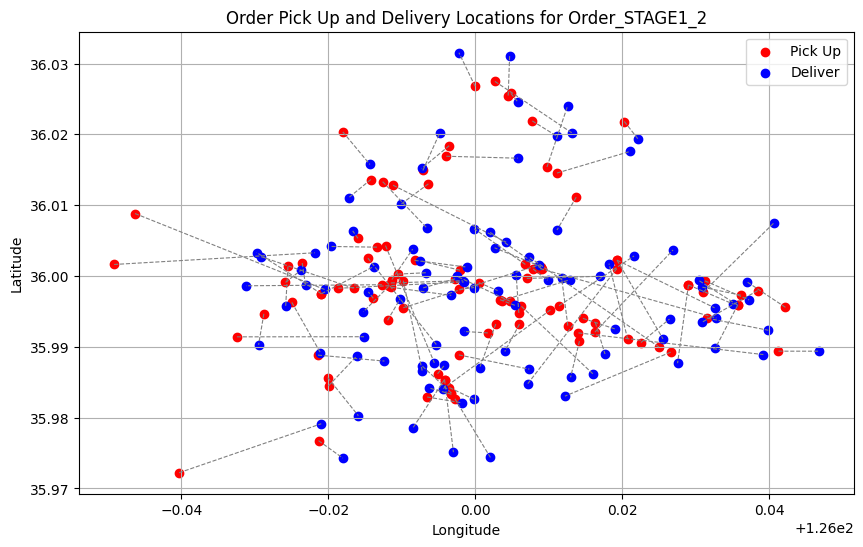

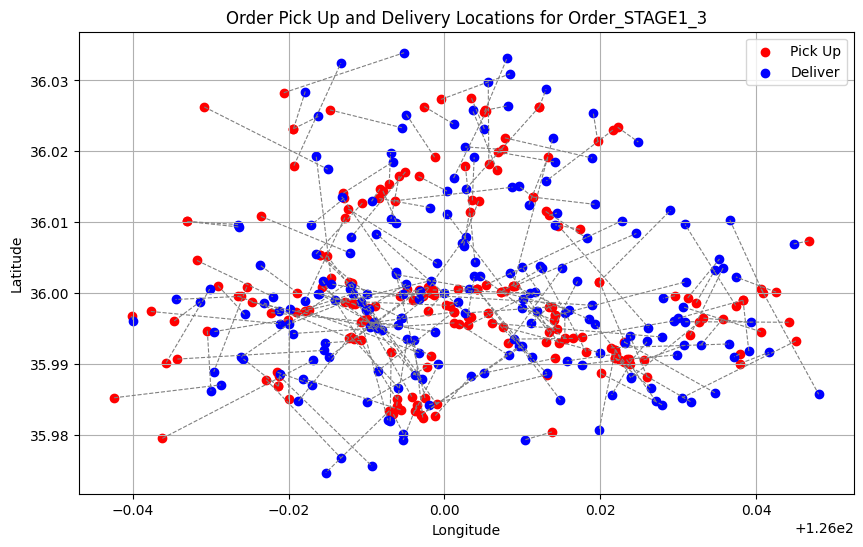

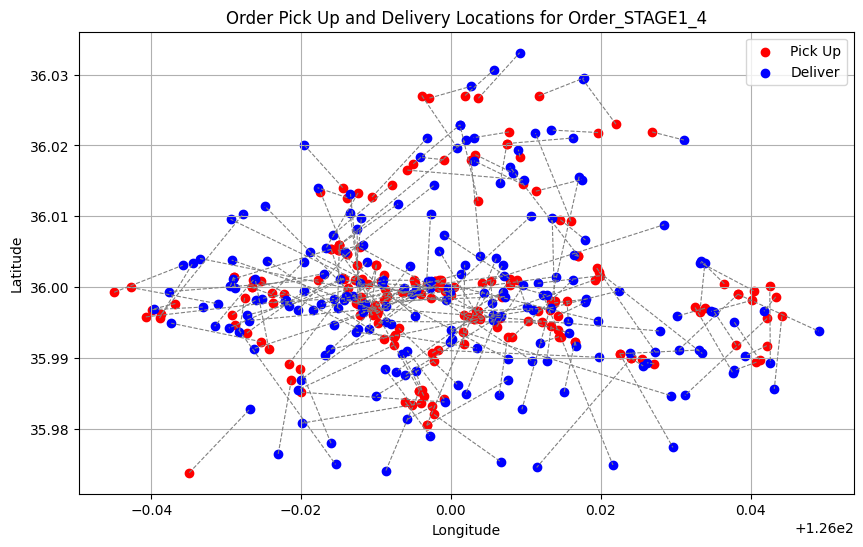

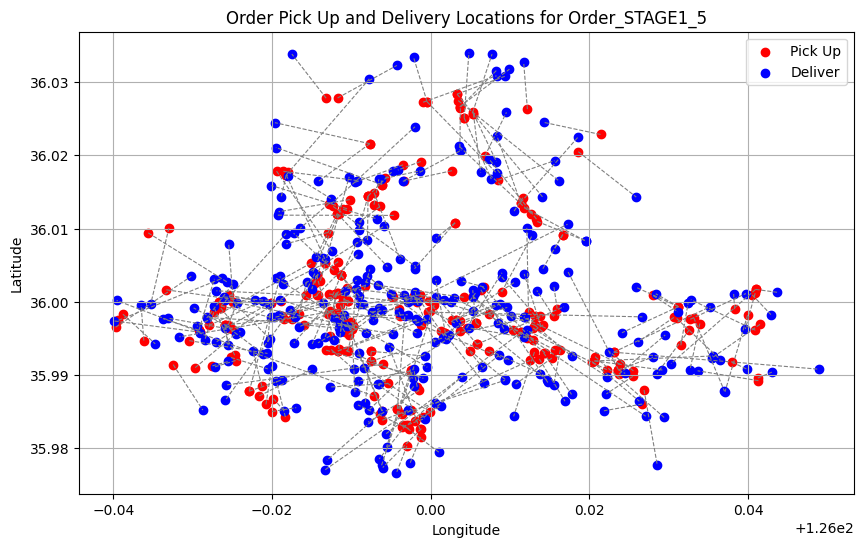

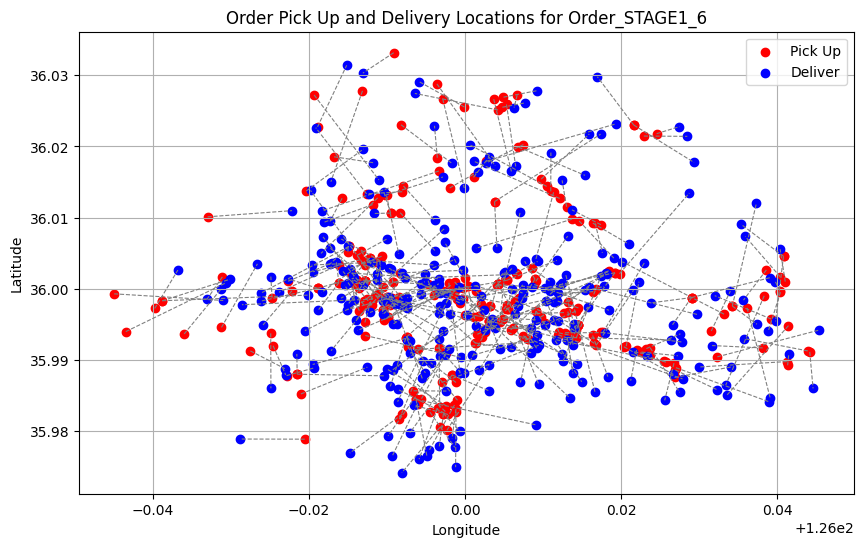

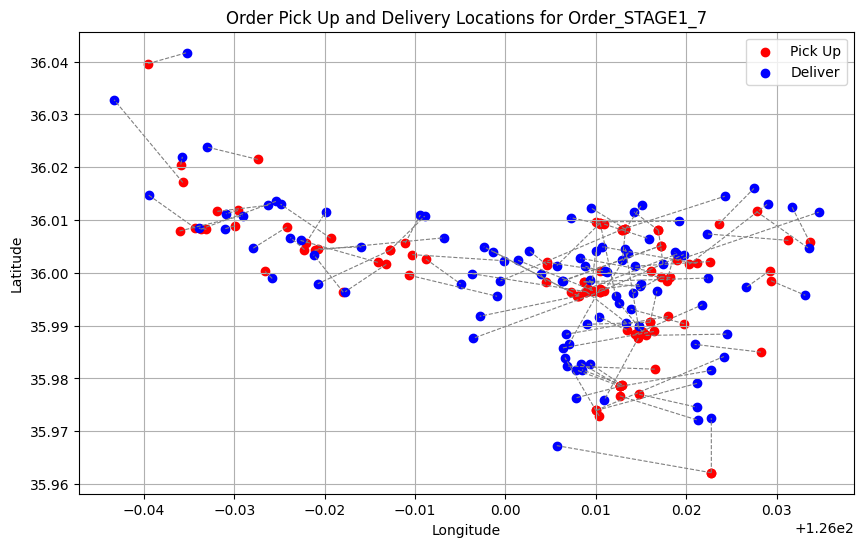

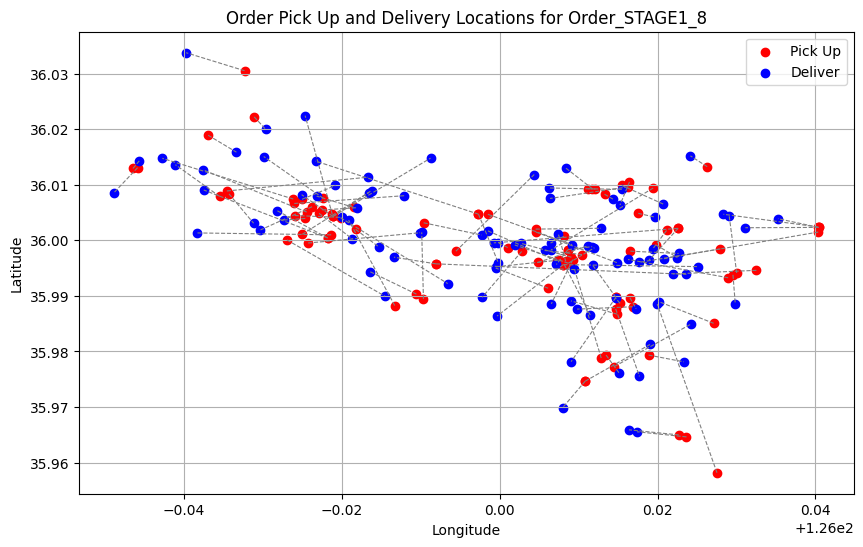

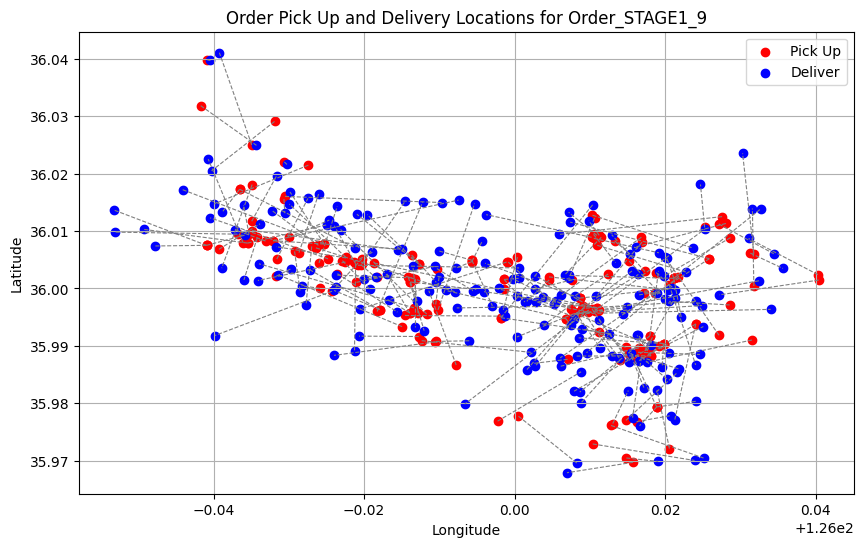

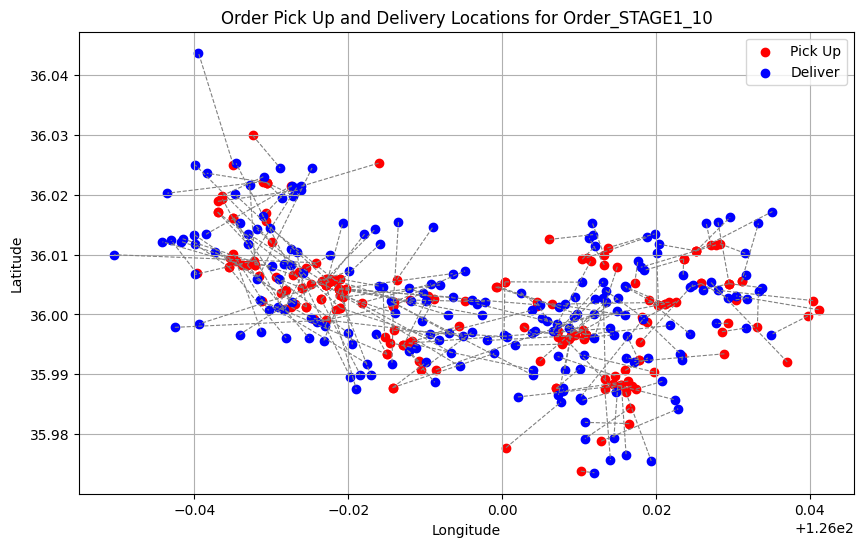

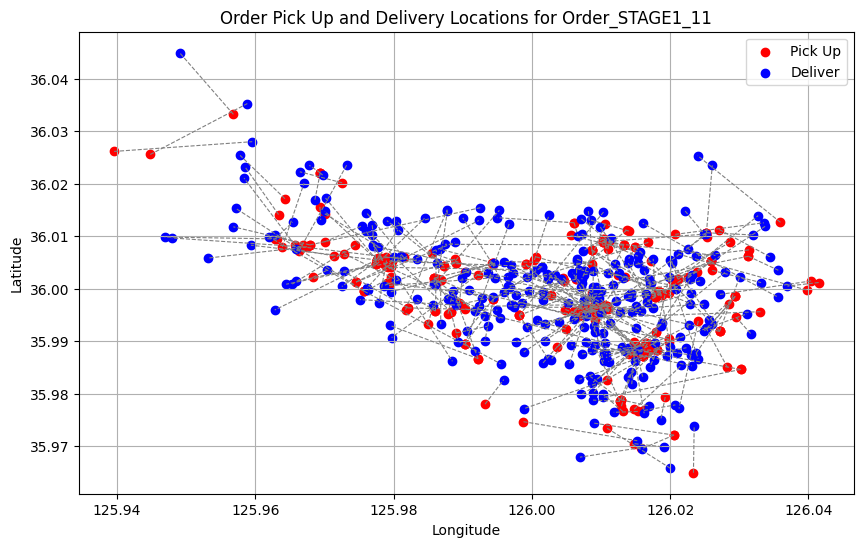

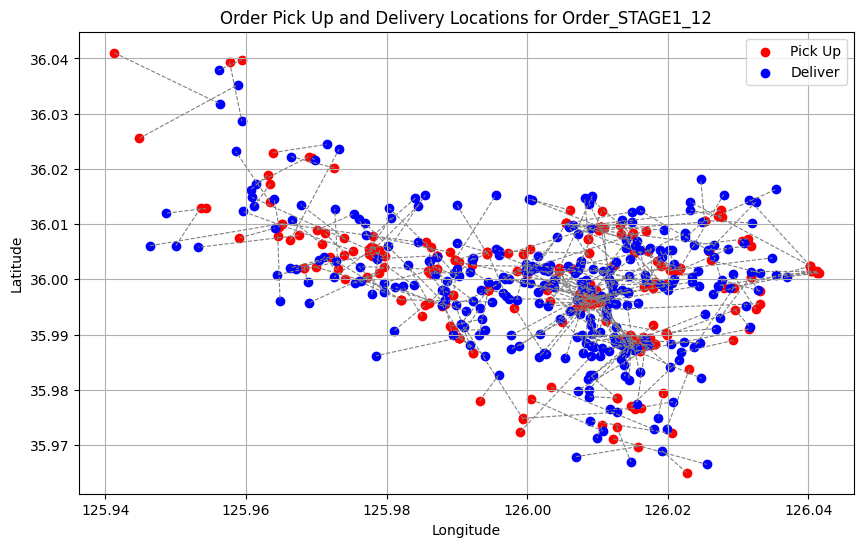

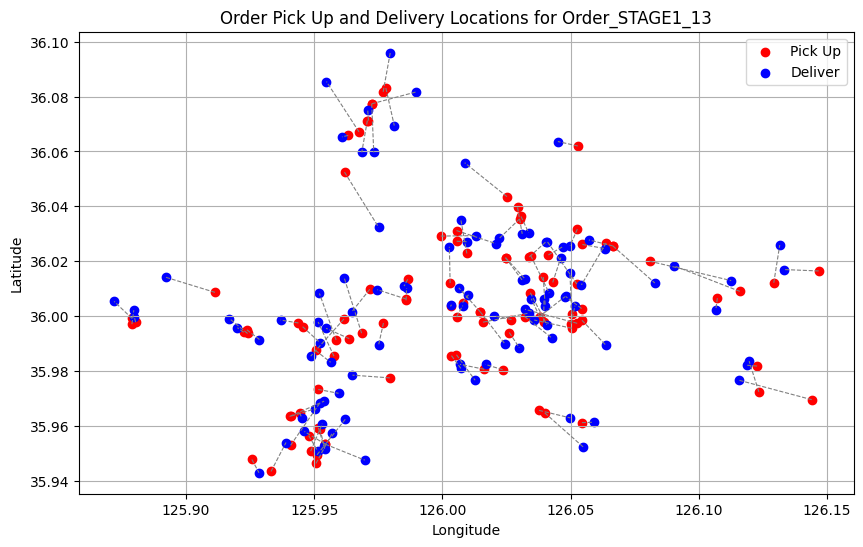

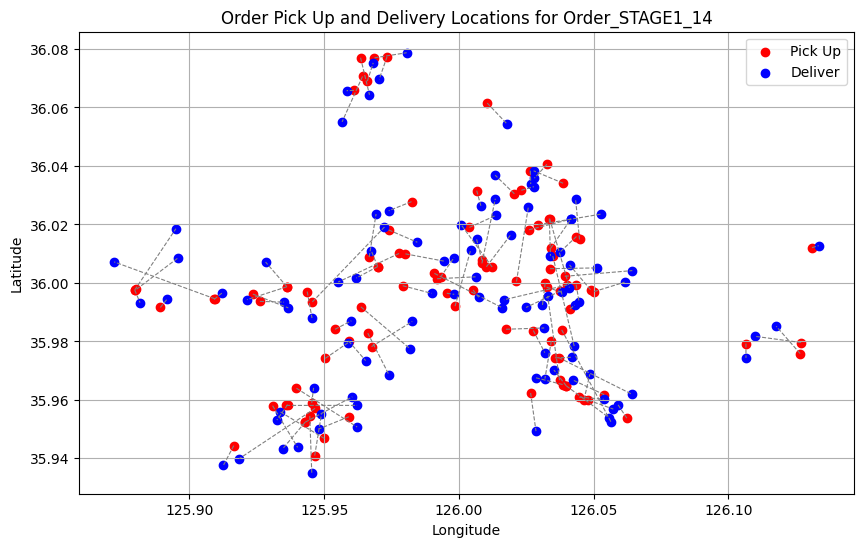

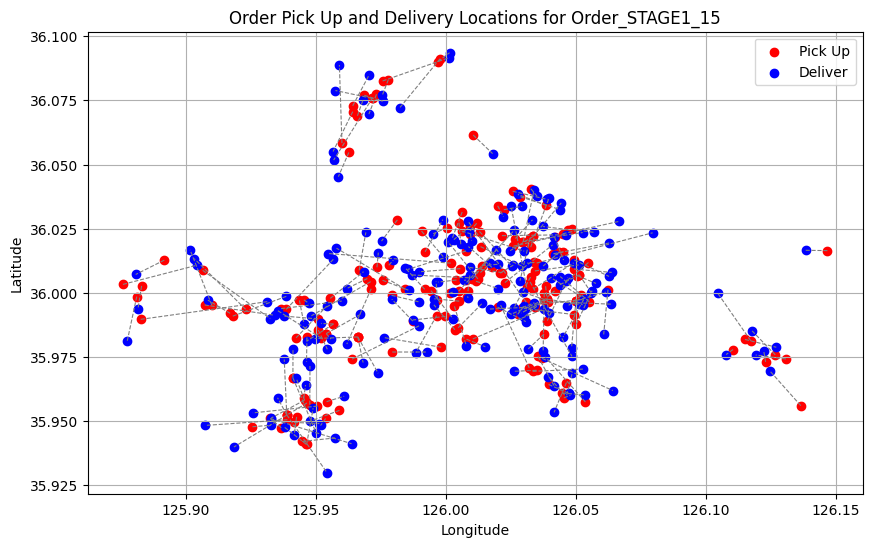

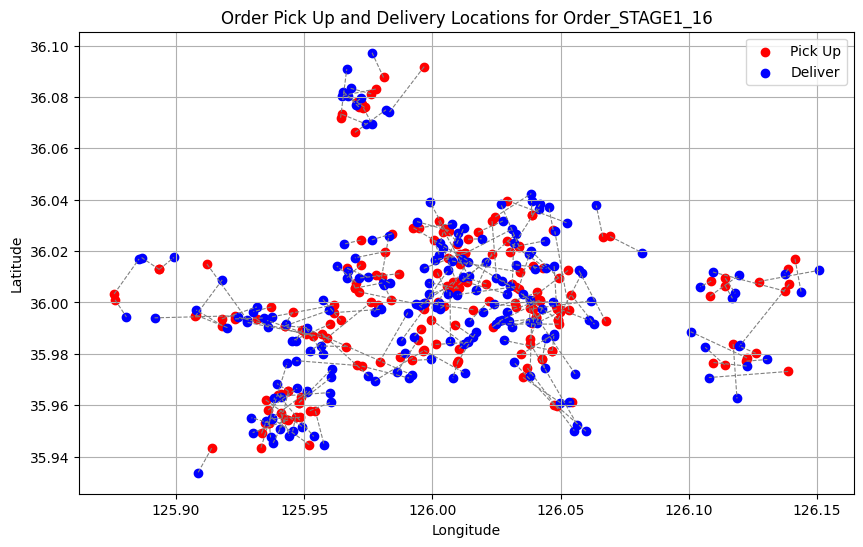

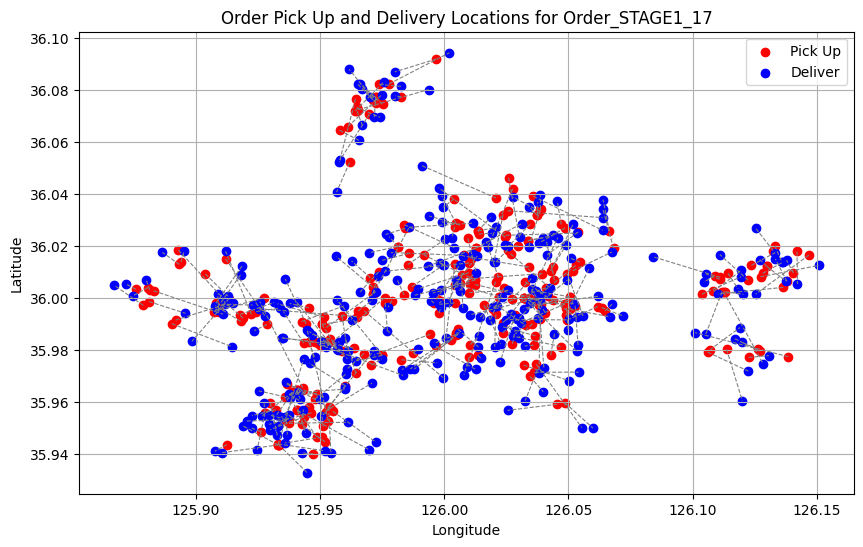

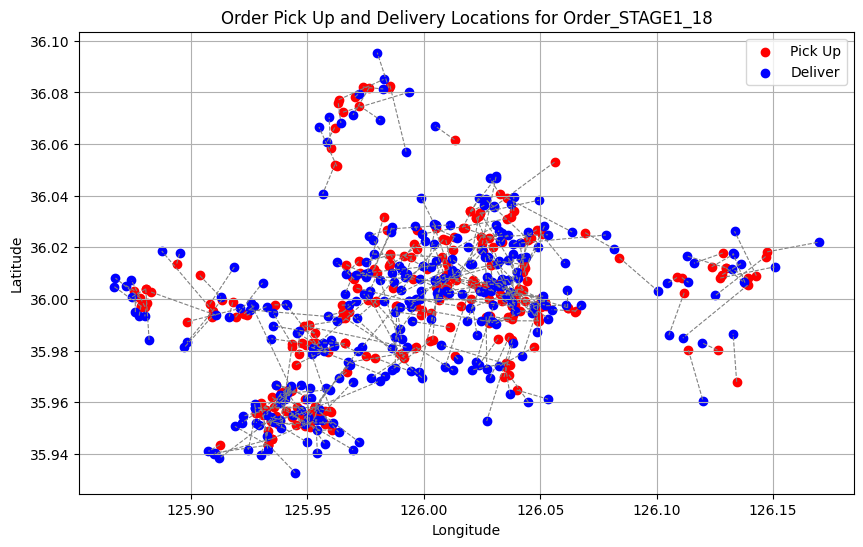

In [3]:
# 엑셀 파일 읽기
file_path = 'OGC2024_problem_description.xlsx'
xls = pd.ExcelFile(file_path)

# 모든 시트의 이름을 가져옴
sheet_names = xls.sheet_names

# 각 시트의 데이터를 읽어서 시각화
for sheet_name in sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name)
    
    # 픽업 장소 (빨강)와 배송 장소 (파랑)를 지도에 표시하고 선으로 연결
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Shop Longitude'], df['Shop Latitude'], color='red', label='Pick Up')
    plt.scatter(df['Delivery Longitude'], df['Delivery Latitude'], color='blue', label='Deliver')
    
    for idx in df.index:
        plt.plot([df.loc[idx, 'Shop Longitude'], df.loc[idx, 'Delivery Longitude']],
                 [df.loc[idx, 'Shop Latitude'], df.loc[idx, 'Delivery Latitude']],
                 color='gray', linestyle='--', linewidth=0.8)
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Order Pick Up and Delivery Locations for {sheet_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    if sheet_name == 'Order_STAGE1_18' :
        break

## Clustering with DBSCAN
* only using long, lat info of shop and deliv from each orders

In [1]:
from sklearn.cluster import DBSCAN

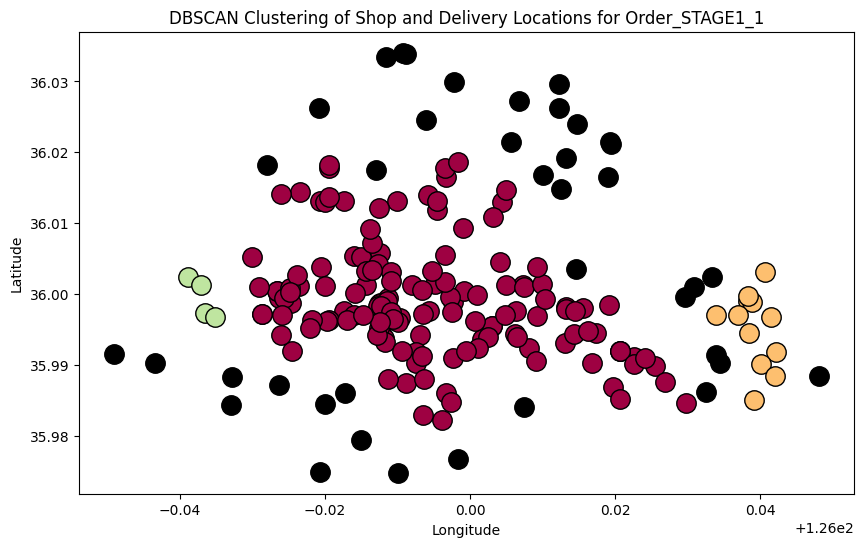

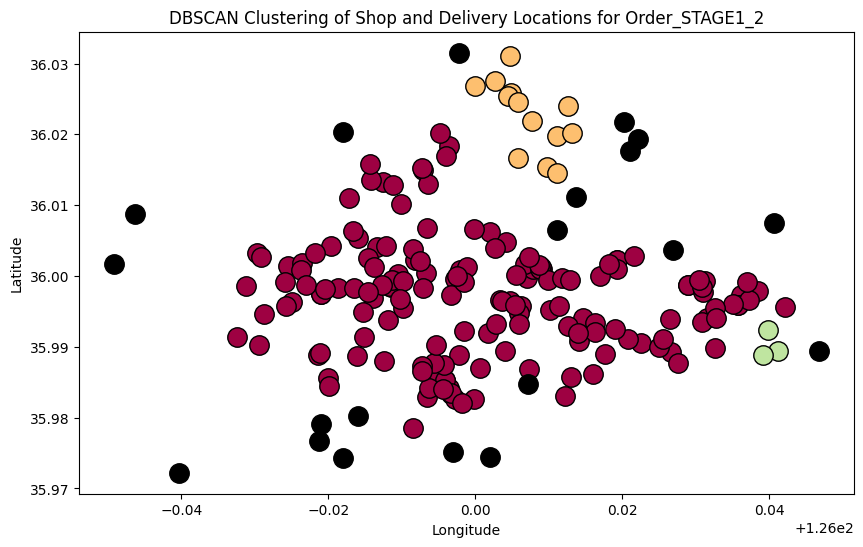

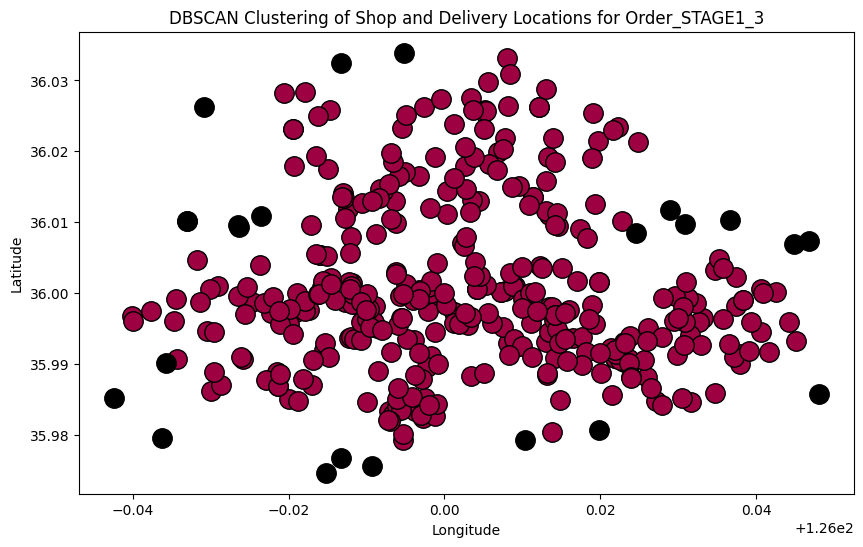

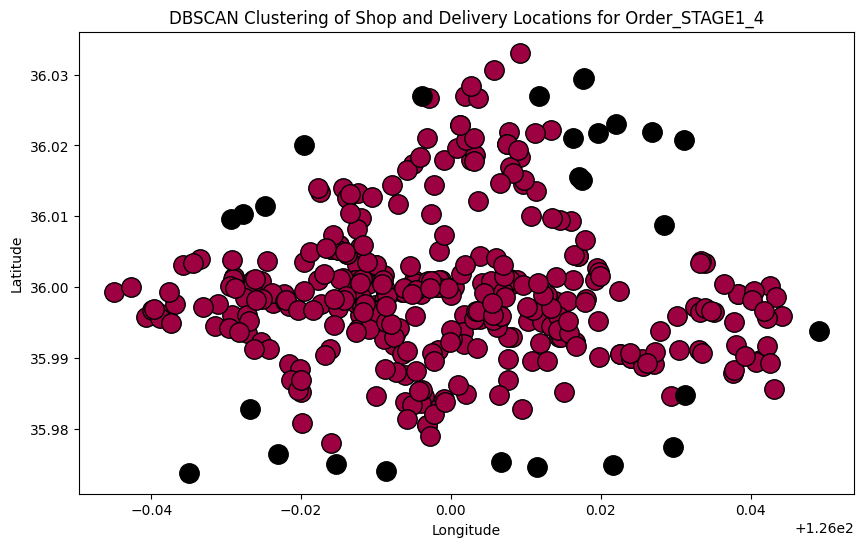

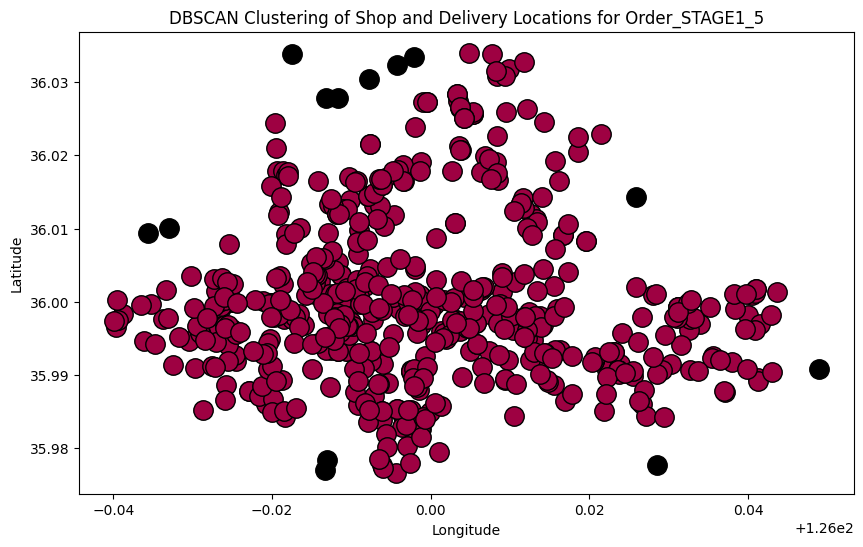

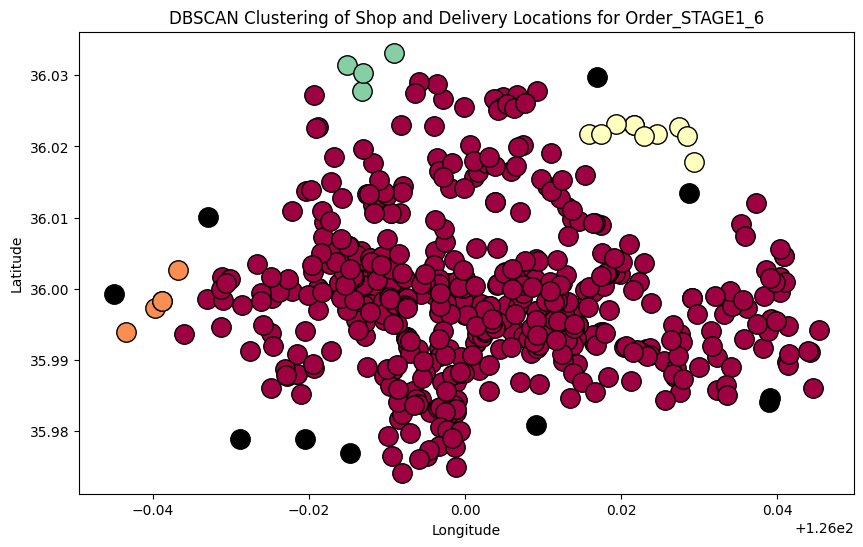

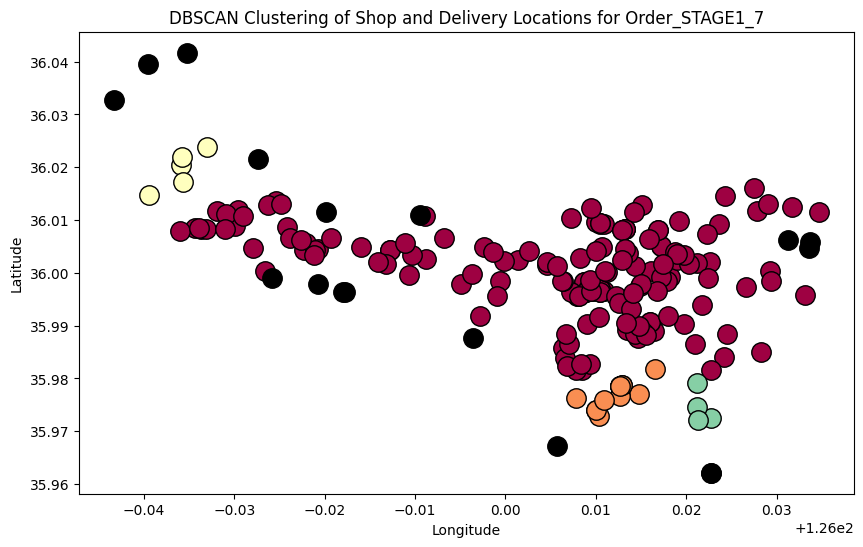

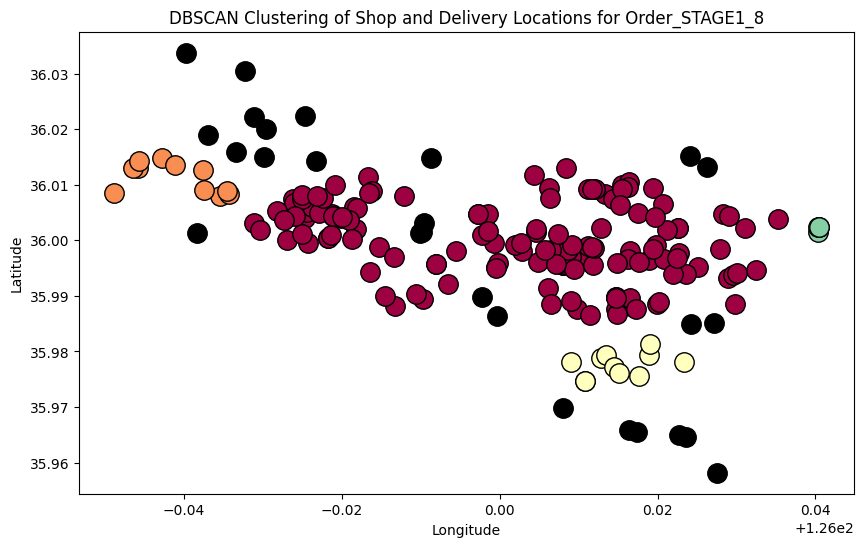

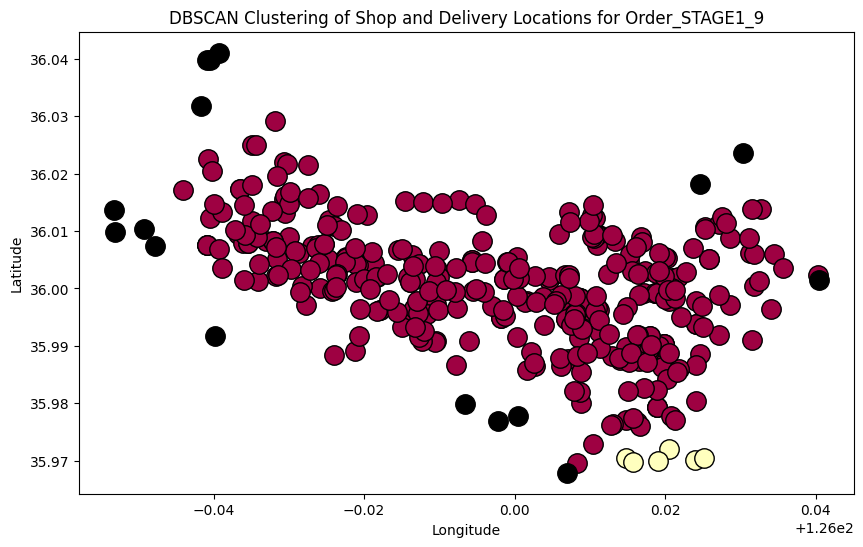

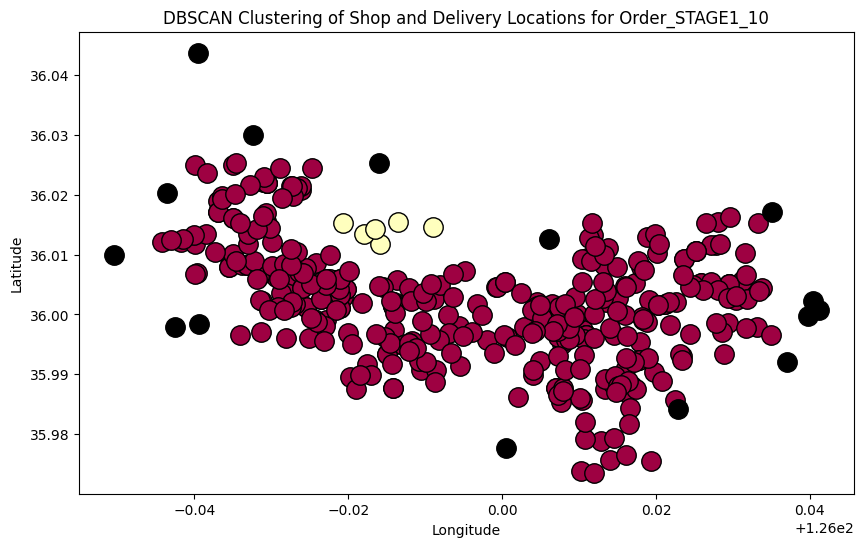

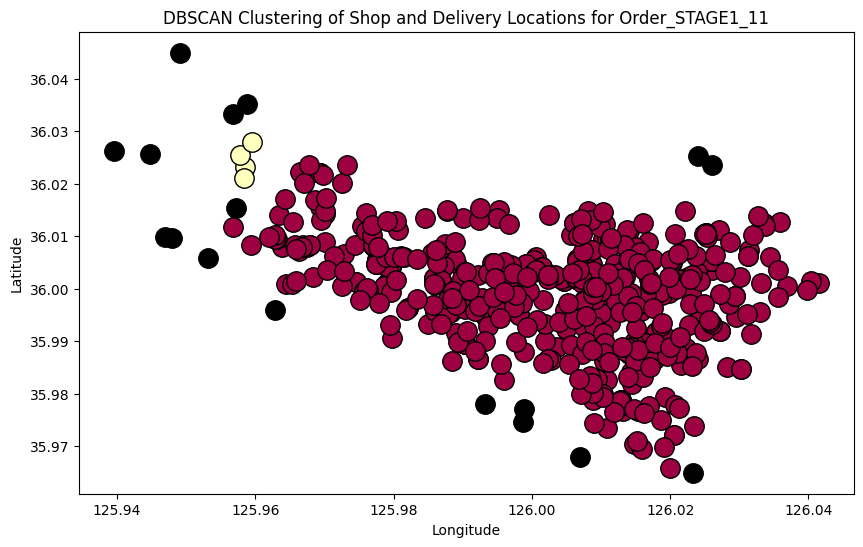

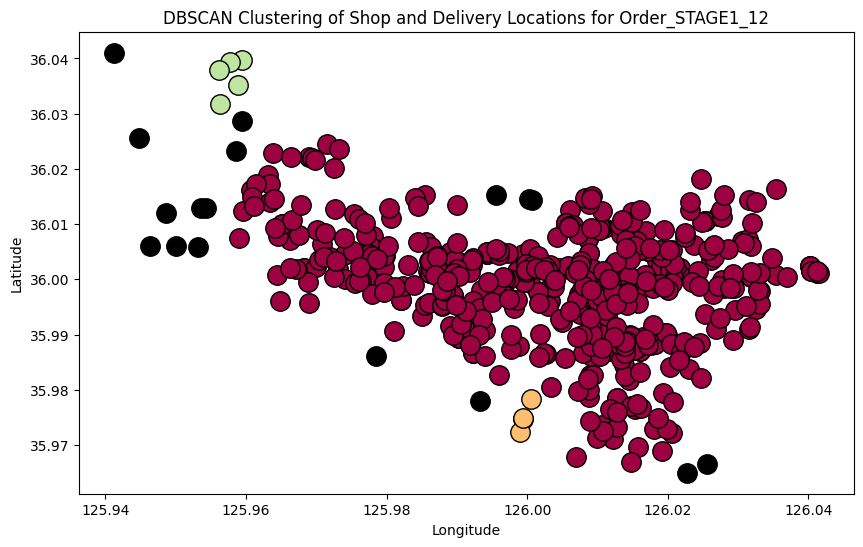

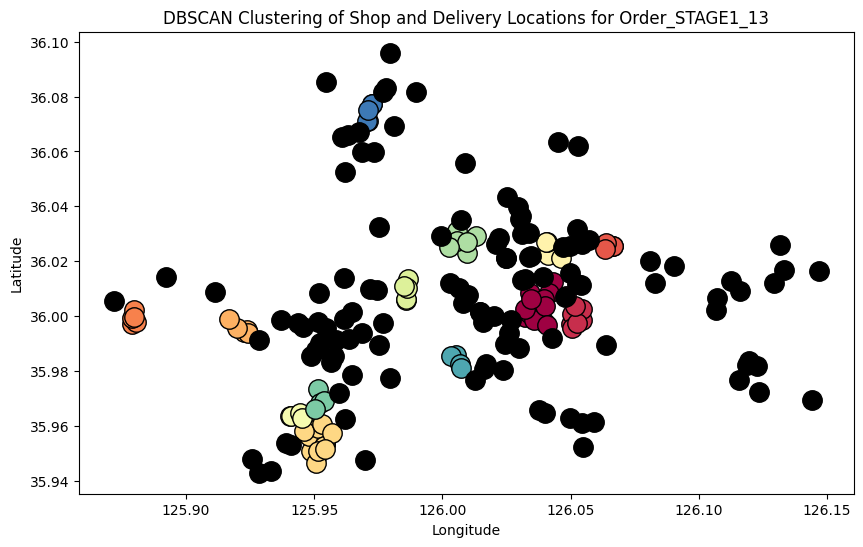

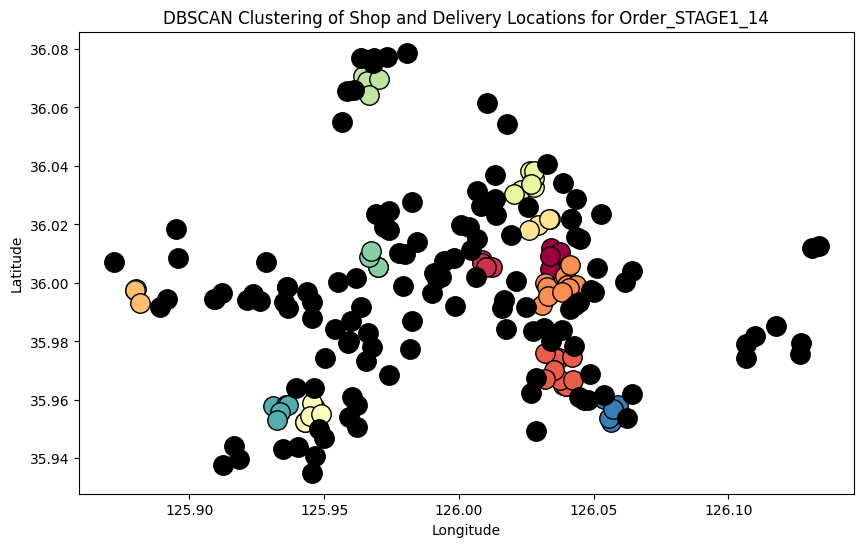

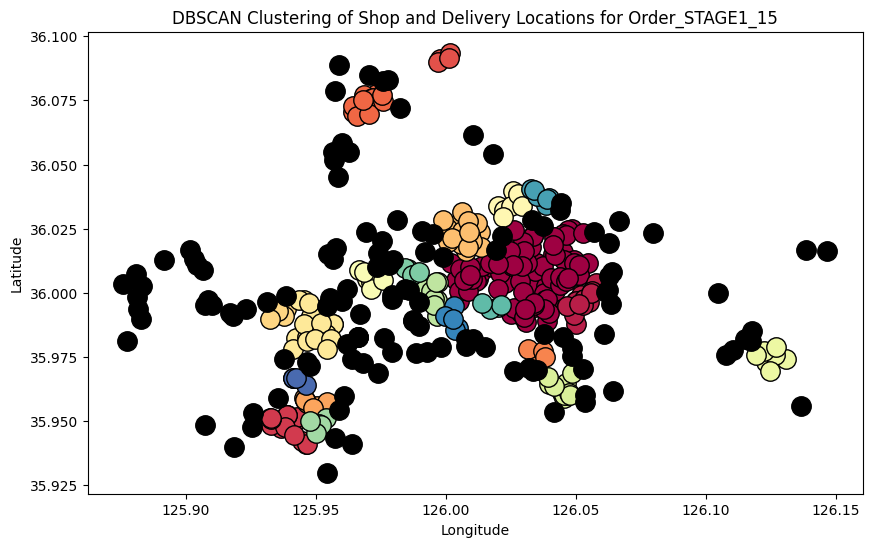

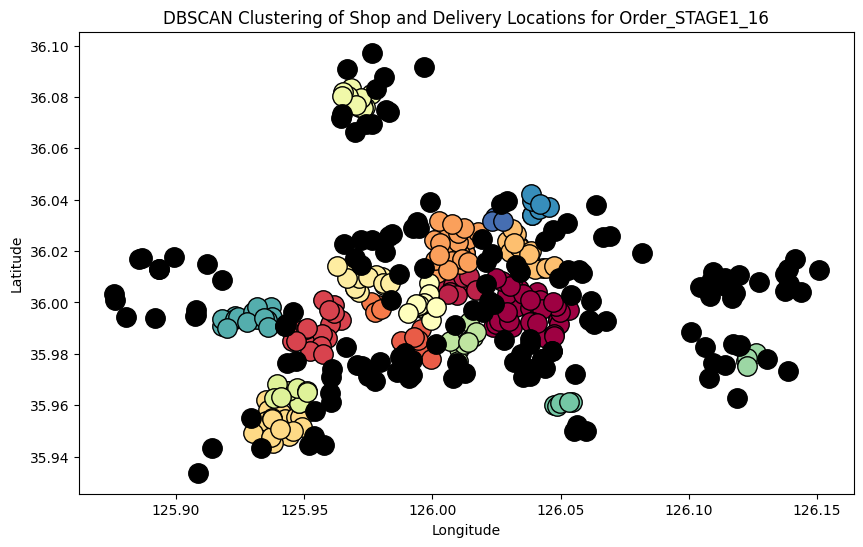

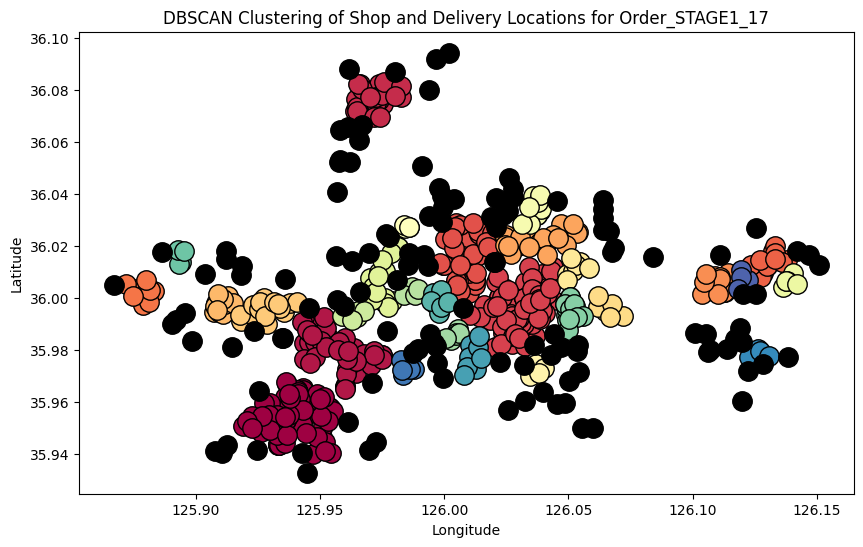

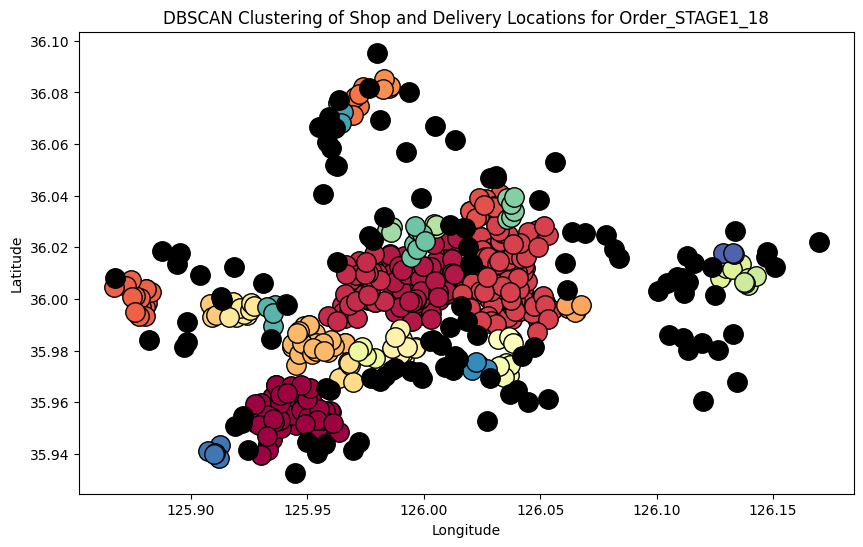

In [29]:
# 엑셀 파일 읽기
file_path = 'OGC2024_problem_description.xlsx'
xls = pd.ExcelFile(file_path)

# 모든 시트의 이름을 가져옴
sheet_names = xls.sheet_names

# 각 시트의 데이터를 읽어서 시각화
for sheet_name in sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name,index_col=0)
    df = df.iloc[:len(df)-2]

    coords = np.vstack((df[['Shop Latitude', 'Shop Longitude']].values, df[['Delivery Latitude', 'Delivery Longitude']].values))

    # DBSCAN 클러스터링 수행
    db = DBSCAN(eps=0.005, min_samples=4).fit(coords)

    # 클러스터 레이블
    labels = db.labels_

    # 결과를 데이터프레임에 추가
    df['shop_cluster'] = labels[:len(df)]
    df['dlv_cluster'] = labels[len(df):]

    # 클러스터링 결과 시각화
    plt.figure(figsize=(10, 6))
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # 노이즈 포인트는 검은색으로 표시
            col = [0, 0, 0, 1]
        
        class_member_mask = (labels == k)
        xy = coords[class_member_mask]
        plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

    plt.title(f'DBSCAN Clustering of Shop and Delivery Locations for {sheet_name}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    if sheet_name == 'Order_STAGE1_18' :
        break